# Results Analysis

## Environment Set Up

### Imports

In [1]:
# System
import os
from tqdm import tqdm

# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Torch
import torch

# Monai
from monai.data import DataLoader
from monai.metrics import DiceMetric
from monai.utils import set_determinism
from torch.utils.data import SequentialSampler
from monai.inferers import sliding_window_inference

# Utils
from utils.Transforms import Transforms
from utils.UCSF_Dataset import UCSF_Dataset
from utils.Models import SEGRESNET, UNET, AHNET, UNTR

### CUDA

In [2]:
# Check if CUDA is available
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

# Print the device
print(f"Device: {device}")

Running on GPU
Device: cuda


### Config

In [3]:
# Seeds
seed = 33
set_determinism(seed=seed) # Monai
np.random.seed(seed) # Numpy
torch.manual_seed(seed) # PyTorch

# Others
%matplotlib inline
pd.set_option("display.max_columns", None)

## Load

### Models & Scores

In [4]:
models = {}
for model in os.listdir('outputs'):
	models[model] = {}
	for files in os.listdir(f'outputs/{model}'):
		if files.endswith('.pth'):
			models[model]['model'] = f'outputs/{model}/{files}'
		if files.endswith('.csv'):
			models[model]['scores'] = f'outputs/{model}/{files}'

models

{'AHNet': {'model': 'outputs/AHNet/AHNet_52.pth',
  'scores': 'outputs/AHNet/AHNet_metrics.csv'},
 'SegResNet': {'model': 'outputs/SegResNet/SegResNet_52.pth',
  'scores': 'outputs/SegResNet/SegResNet_metrics.csv'},
 'UNet': {'model': 'outputs/UNet/UNet_52.pth',
  'scores': 'outputs/UNet/UNet_metrics.csv'},
 'UNETR': {'model': 'outputs/UNETR/UNETR_50.pth',
  'scores': 'outputs/UNETR/UNETR_metrics.csv'}}

### Load Test Data

In [5]:
# Load Subjects Information
test_df = pd.read_csv('data/TEST.csv')

# Parameters
b_size = 1
t_size = None

# Transforms
transforms = Transforms(seed)

# Train Dataset
test_images = [test_df['T1pre'], test_df['FLAIR'], test_df['T1post'], test_df['T2Synth']]
test_labels = test_df['BraTS-seg']
test_dataset = UCSF_Dataset(test_images, test_labels, transforms.val(), t_size)

# Samplers
test_sampler = SequentialSampler(test_dataset)

# DataLoaders
test_loader = DataLoader(test_dataset, batch_size=b_size, shuffle=False, sampler=test_sampler)

## Inference Method

In [6]:
# Parameters
VAL_AMP = True
spatial_size = (240, 240, 160)
ah_spatial_size = (256, 256, 160)

# Metrics
dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

# Inference Method
def inference(input, spatial_size):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=spatial_size,
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)
    
# Iterate
def test_model(model, ahnet):
    
	# Params
    metric_values = []
    metric_values_tc = []
    metric_values_wt = []
    metric_values_et = []

	# Model
    model.eval()
    
	# Infer
    with torch.no_grad():
        for test_data in tqdm(test_loader):
            
            # Load Data
            test_inputs, test_labels = (
				test_data["image"].to(device),
				test_data["label"].to(device),
			)
            
			# Infer Data
            test_outputs = None
            if ahnet:
                  test_outputs = inference(test_inputs, ah_spatial_size)
            else:
                   test_outputs = inference(test_inputs, spatial_size)
            test_outputs = [transforms.post()(x) for x in test_outputs]

			# Plot Image
            #plot_gt_vs_pred(test_labels[0], test_outputs[0], False)
            
			# Mean Dice
            dice_metric(y_pred=test_outputs, y=test_labels)
            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            
			# Batch Dice
            dice_metric_batch(y_pred=test_outputs, y=test_labels)
            metric_batch = dice_metric_batch.aggregate()
            # TC
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            # WT
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            # ET
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            # Reset
            dice_metric.reset()
            dice_metric_batch.reset()
    
    # Excel
    df = pd.DataFrame({
		'Dice': metric_values,
		'Dice TC': metric_values_tc,
		'Dice WT': metric_values_wt,
		'Dice ET': metric_values_et
	})
    
    return df

## Training Loss

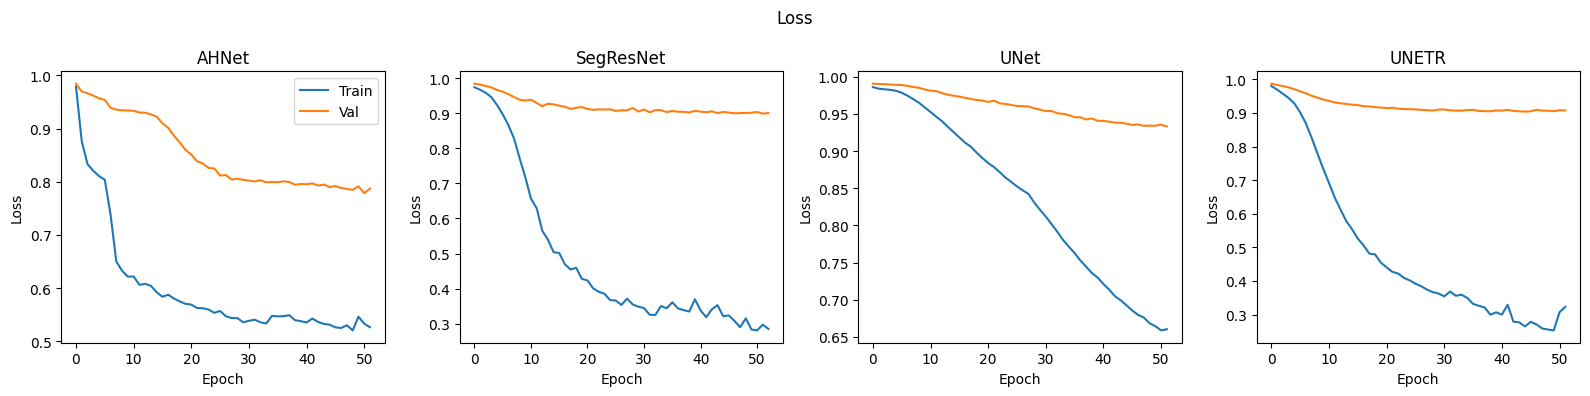

In [7]:
plt.figure(figsize=(16, 4))

for i, model in enumerate(models.keys()):

	# Load scores
	scores = pd.read_csv(models[model]['scores'])

	# Plot
	plt.subplot(1, len(models), i+1)
	plt.plot(scores["train_loss"], label='Train')
	plt.plot(scores["val_loss"], label='Val')
	plt.title(model)
	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	if i == 0:
		plt.legend()

plt.suptitle("Loss")
plt.tight_layout()
plt.show()

## Training Dice

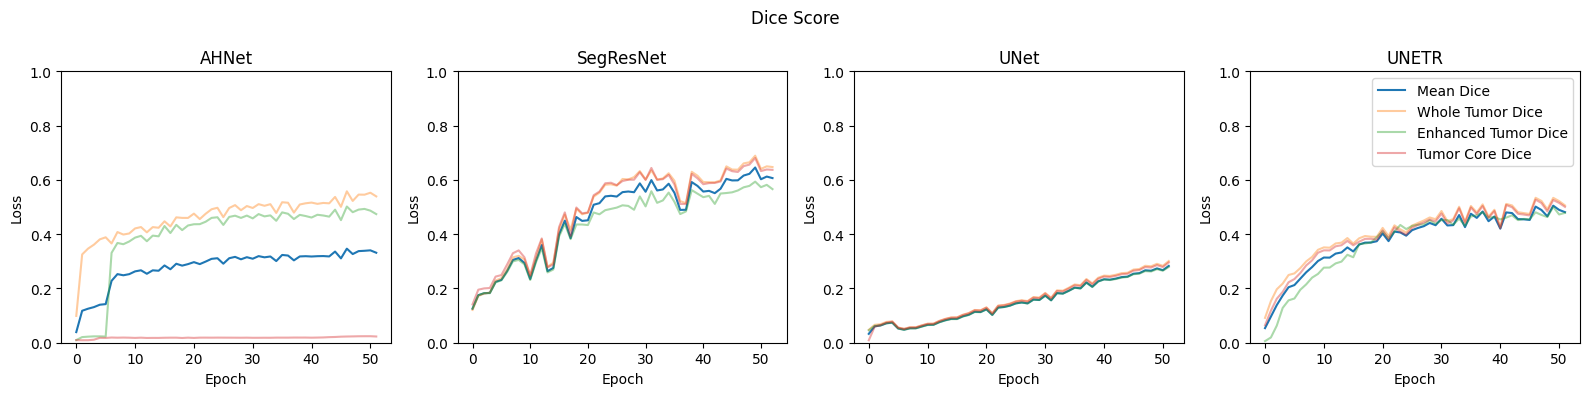

In [8]:
plt.figure(figsize=(16, 4))

for i, model in enumerate(models.keys()):
	
	# Load scores
	scores = pd.read_csv(models[model]['scores'])

	# Plots
	plt.subplot(1, len(models), i+1)
	plt.plot(scores["metric"], label='Mean Dice')
	plt.plot(scores["metric_wt"], label='Whole Tumor Dice', alpha=0.4)
	plt.plot(scores["metric_et"], label='Enhanced Tumor Dice', alpha=0.4)
	plt.plot(scores["metric_tc"], label='Tumor Core Dice', alpha=0.4)
	plt.title(model)
	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	plt.ylim(0, 1)
	if i == 3:
		plt.legend()

plt.suptitle("Dice Score")
plt.tight_layout()
plt.show()

## Test Dice

In [9]:
# AHNet
model = AHNET
model.to(device)
model.load_state_dict(torch.load(models['AHNet']['model']))
AHNet_scores = test_model(model, True)
AHNet_scores.describe()

100%|██████████| 31/31 [04:42<00:00,  9.13s/it]


,Dice,Dice TC,Dice WT,Dice ET
count,31.000000,31.000000,31.000000,31.000000
mean,0.344960,0.020747,0.544641,0.469493
std,0.210151,0.033282,0.317117,0.298167
min,0.000008,0.000018,0.000000,0.000000
25%,0.186890,0.000713,0.285333,0.251713
50%,0.356380,0.003883,0.587708,0.506024
75%,0.525448,0.027766,0.804322,0.729567
max,0.619494,0.122352,0.920847,0.892550


In [10]:
# SegResNet
model = SEGRESNET
model.to(device)	
model.load_state_dict(torch.load(models['SegResNet']['model']))
SegResNet_scores = test_model(model, False)

SegResNet_scores.describe()

100%|██████████| 31/31 [06:50<00:00, 13.25s/it]


,Dice,Dice TC,Dice WT,Dice ET
count,31.000000,31.000000,31.000000,31.000000
mean,0.582126,0.612991,0.626981,0.496239
std,0.274957,0.267456,0.271913,0.310206
min,0.000000,0.000000,0.000000,0.000000
25%,0.390501,0.453133,0.472817,0.211372
50%,0.607504,0.665362,0.711740,0.477767
75%,0.818572,0.848481,0.863639,0.742881
max,0.947788,0.955580,0.958183,0.929602


In [11]:
# UNet
model = UNET
model.to(device)
model.load_state_dict(torch.load(models['UNet']['model']))
UNet_scores = test_model(model, False)

UNet_scores.describe()

100%|██████████| 31/31 [02:10<00:00,  4.20s/it]


,Dice,Dice TC,Dice WT,Dice ET
count,31.000000,31.000000,31.000000,31.000000
mean,0.323802,0.340657,0.351281,0.279469
std,0.340986,0.347964,0.358545,0.321828
min,0.000000,0.000000,0.000000,0.000000
25%,0.010907,0.013176,0.012997,0.006847
50%,0.161159,0.186964,0.205149,0.134247
75%,0.652499,0.651876,0.718070,0.587551
max,0.894217,0.903274,0.912896,0.879840


In [12]:
# UNETR
model = UNTR
model.to(device)
model.load_state_dict(torch.load(models['UNETR']['model']))
UNetR_scores = test_model(model, False)

UNetR_scores.describe()

100%|██████████| 31/31 [07:26<00:00, 14.42s/it]


,Dice,Dice TC,Dice WT,Dice ET
count,31.000000,31.000000,31.000000,31.000000
mean,0.488059,0.516341,0.527794,0.418509
std,0.313108,0.303710,0.310325,0.345141
min,0.015781,0.018116,0.022247,0.000000
25%,0.252771,0.268349,0.278385,0.122350
50%,0.410930,0.482211,0.500483,0.363593
75%,0.816311,0.838670,0.850120,0.761983
max,0.943981,0.949177,0.950335,0.932998
